In [95]:
#pip install geopandas matplotlib

## INTRODUTION 
##### Our project combines poverty, food access, and crime data to determine neighborhood livability. We also considered looking at average income, but we decided that it would be represented between our poverty and crime data. We also gave more weight to food access, because while there was a range of crime scores for each neighborhood, we empirically noticed that neighborhoods we considered to be "nicer" had less violent crime. 

## THE METRIC
##### Our analysis on poverty and food gave us additional insight into the livability of Pittsburgh's neighborhoods. Poverty rate is an integral metric when determining the livability of any given community, with lower-income areas receiving less money, having fewer/worse/poorly maintained public facilities, as well as being more dangerous. We also considered the accessibility of grocery stores within any given neighborhood. According to a 2012 US dept. of Treasury report, almost half of Pittsburgh's residents live in food deserts, or areas where access to healthy food is limited. Because most people consume food, the walkable accessibility of grocery stores is important for quality of life. This also promotes varied diets, leading to healthier lifestyles and quality of life, and discourages car-structured neighborhoods and infrastructure. The dataset we used was a list of the 1216 grocery stores, bodegas, delis, and convenience stores in Pittsburgh. No neighborhood was given, so we had to match the coordinates with a shape file for the Pittsburgh neighborhoods, and place the stores in their respective neighborhods this way. When calculating food access per neighborhood, grocery stores were given a weight of 4 and conveniences stores were given a weight of 1. We then normalized this metric, as well as the poverty metric, on a 0-1 scale. We should note that our poverty dataset was definitely inaccurate.

##### We also analyzed data on crime to better understand the safety of each neighborhood in Pittsburgh. Crime is an important part in determining quality of life in a given neighborhood. High-crime areas are typically less attractive for people to visit and live in. In our analysis of crime, we looked at how many arrests occurred in each neighborhood and which crimes were the highest in each neighborhood. The type of offense matters when drawing conclusions on livability because non-violent crimes do not tarnish the safety of a given neighborhood. Pairing crime with the each neighborhood's population allows for us to look at the crime rate in each neighborhood to determine how many arrests occur in each neighborhood over a given year. The datasets we used to measure crime and crime rate were firstly, a dataset containing 66,482 arrests throughout all Pittsburgh's neighborhoods, and secondly, a population dataframe in each of Pittsburgh's neighborhoods for the years 2010 and 2020. We then compared these two dataframes to look at crime rate, measured on a scale from 0-0.2. We had to remove two neighborhoods because their low populations skewed the crime rate data. It is worth noting that a few neighborhoods were named differently in the two dataframes and therefore could not be included in the crime rate analysis.

In [108]:
import geopandas as gpd
from shapely.geometry import Point
import requests
import json
import pandas as pd

#MERGED DF 1
pov_url = 'https://data.wprdc.org/dataset/c6265ffb-c86e-4a2c-870b-1aaa0772c449/resource/7996d143-c155-466e-8414-115f74997dd7/download/poverty-status-of-individuals-in-the-past-12-months-by-living-arrangement.csv';
pop_url = 'https://data.wprdc.org/dataset/95af9f2c-61c8-446b-ae72-852e195684f3/resource/a8414ed5-c50f-417e-bb67-82b734660da6/download/preliminarycitypittsburghneighborhood_pl94171summary-2.csv'
income_url = 'https://data.wprdc.org/dataset/c6265ffb-c86e-4a2c-870b-1aaa0772c449/resource/41d215a7-6baf-4de8-8593-d25c858d3546/download/aggregate-household-income-in-the-past-12-months-in-2014-inflation-adjusted-dollars.csv'
income = pd.read_csv(income_url)
poverty = pd.read_csv(pov_url)
population = pd.read_csv(pop_url)
poverty.rename(columns={'Estimate; Income in the past 12 months below poverty level:': 'income_12mo_below_pov'}, inplace=True)
income.rename(columns={'Estimate; Aggregate household income in the past 12 months (in 2014 Inflation-adjusted dollars)': 'agg_income_past_12mo'}, inplace=True)

#MERGED DF 2 (THE GIS ONE)
food_url = 'https://data.wprdc.org/dataset/690409e3-27e2-47a1-beed-fd600097f951/resource/626357fa-c95d-465f-9a02-3121655b2b78/download/data-conveniencesupermarkets.csv'
food = pd.read_csv(food_url)
#Pittsburgh neighborhood locations
file_path = "C:/Users/Ben/Documents/School things/gn-pittsburgh.geojson"

with open(file_path, 'r') as f:
    data = json.load(f)

features = data['features']

In [109]:

neighborhoods = gpd.read_file(file_path)
crs = 'EPSG:4326' 

food_geo = [Point(xy) for xy in zip(food.Lon, food.Lat)]
geo_df = gpd.GeoDataFrame(food, crs=crs, geometry=food_geo)

In [110]:
stores_per_neighborhood = gpd.sjoin(neighborhoods, geo_df, how="left", op="contains")
stores_per_neighborhood = stores_per_neighborhood[['name', 'Category', 'geometry']]
stores_per_neighborhood.head()

B:\Anaconda\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,name,Category,geometry
0,South Side Flats,Convenience Store,"MULTIPOLYGON (((-79.97726 40.43273, -79.97725 ..."
0,South Side Flats,Supermarket,"MULTIPOLYGON (((-79.97726 40.43273, -79.97725 ..."
0,South Side Flats,Convenience Store,"MULTIPOLYGON (((-79.97726 40.43273, -79.97725 ..."
0,South Side Flats,Convenience Store,"MULTIPOLYGON (((-79.97726 40.43273, -79.97725 ..."
0,South Side Flats,Convenience Store,"MULTIPOLYGON (((-79.97726 40.43273, -79.97725 ..."


In [111]:
stores_per_neighborhood = gpd.sjoin(neighborhoods, geo_df, how="left", op="contains")

stores_per_neighborhood['weight'] = stores_per_neighborhood['Category'].apply(lambda x: 4 if x == 'Supermarket' else 1)

stores_count = stores_per_neighborhood.groupby('name').agg({'weight': 'sum', 'geometry': 'first'}).reset_index()

stores_count = stores_count.rename(columns={'weight': 'Food_Access'})

stores_count.head()


B:\Anaconda\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,name,Food_Access,geometry
0,Allegheny Center,1,"MULTIPOLYGON (((-80.00149 40.45269, -80.00146 ..."
1,Allegheny West,1,"MULTIPOLYGON (((-80.01457 40.45397, -80.01453 ..."
2,Allentown,1,"MULTIPOLYGON (((-79.99966 40.42812, -79.99960 ..."
3,Arlington,1,"MULTIPOLYGON (((-79.95773 40.41870, -79.95769 ..."
4,Arlington Heights,1,"MULTIPOLYGON (((-79.96027 40.41809, -79.96023 ..."


In [112]:
stores_count = stores_count.rename(columns={'name': 'Neighborhood', 'geometry': 'Geometry'})
stores_count.head(20)

,Neighborhood,Food_Access,Geometry
0,Allegheny Center,1,"MULTIPOLYGON (((-80.00149 40.45269, -80.00146 ..."
1,Allegheny West,1,"MULTIPOLYGON (((-80.01457 40.45397, -80.01453 ..."
2,Allentown,1,"MULTIPOLYGON (((-79.99966 40.42812, -79.99960 ..."
3,Arlington,1,"MULTIPOLYGON (((-79.95773 40.41870, -79.95769 ..."
4,Arlington Heights,1,"MULTIPOLYGON (((-79.96027 40.41809, -79.96023 ..."
5,Banksville,5,"MULTIPOLYGON (((-80.02969 40.42126, -80.02975 ..."
6,Bedford Dwellings,1,"MULTIPOLYGON (((-79.96568 40.45367, -79.96524 ..."
7,Beechview,5,"MULTIPOLYGON (((-80.02120 40.42342, -80.02110 ..."
8,Beltzhoover,2,"MULTIPOLYGON (((-79.99887 40.42173, -79.99853 ..."
9,Bloomfield,20,"MULTIPOLYGON (((-79.93938 40.46453, -79.93933 ..."


In [125]:
merged_df = pd.merge(income, poverty, on="Neighborhood", how='left')
merged_df = merged_df[["Neighborhood", "Estimate; Total:","income_12mo_below_pov"]]

merged_df = merged_df[merged_df['Neighborhood'] != 'South Shore']


merged_df.sort_values(by='income_12mo_below_pov').tail(50)



,Neighborhood,Estimate; Total:,income_12mo_below_pov
85,Upper Hill,1929.0,528.0
16,Central Business District,2655.0,533.0
50,Middle Hill,1675.0,545.0
8,Beltzhoover,1885.0,554.0
89,Westwood,3550.0,558.0
44,Larimer,1504.0,595.0
88,West Oakland,1317.0,623.0
61,Perry North,4062.0,645.0
17,Central Lawrenceville,4356.0,664.0
29,Elliott,2452.0,668.0


In [135]:
income_pov_food = pd.merge(merged_df, stores_count, on='Neighborhood', how='left')
income_pov_food.sort_values('Food_Access', ascending=False).head()

,Neighborhood,Estimate; Total:,income_12mo_below_pov,Food_Access,Geometry
15,Carrick,10045.0,1993.0,24.0,"MULTIPOLYGON (((-79.99194 40.40718, -79.99191 ..."
79,Strip District,689.0,33.0,21.0,"MULTIPOLYGON (((-79.97494 40.45629, -79.97484 ..."
9,Bloomfield,8702.0,1760.0,20.0,"MULTIPOLYGON (((-79.93938 40.46453, -79.93933 ..."
68,Shadyside,12778.0,2579.0,18.0,"MULTIPOLYGON (((-79.91501 40.45582, -79.91416 ..."
16,Central Business District,2655.0,533.0,17.0,"MULTIPOLYGON (((-79.99237 40.44483, -79.99232 ..."


In [144]:
import numpy as np

income_pov_food = income_pov_food.rename(columns={'Estimate; Total:': 'Population', 'income_12mo_below_pov' : 'Pop. in Poverty'})
income_pov_food['% in Poverty'] = income_pov_food['Pop. in Poverty'] / income_pov_food['Population']
income_pov_food['Food_Per_Cap'] = income_pov_food['Food_Access'] / income_pov_food['Population']

income_pov_food['Poverty_Norm'] = (income_pov_food['% in Poverty'] - income_pov_food['% in Poverty'].min()) / (income_pov_food['% in Poverty'].max() - income_pov_food['% in Poverty'].min())
income_pov_food['Poverty_Norm_Inverted'] = 1 - income_pov_food['Poverty_Norm']

income_pov_food['Food_Per_Cap'] = income_pov_food['Food_Per_Cap'].replace([np.inf, -np.inf], np.nan)

income_pov_food['Food_Norm'] = (income_pov_food['Food_Per_Cap'] - income_pov_food['Food_Per_Cap'].min()) / (income_pov_food['Food_Per_Cap'].max() - income_pov_food['Food_Per_Cap'].min())

income_pov_food.reset_index(drop=True, inplace=True)


income_pov_food.sort_values('% in Poverty').tail(20)

,Neighborhood,Population,Pop. in Poverty,Food_Access,Geometry,% in Poverty,Food_Per_Cap,Poverty_Norm,Poverty_Norm_Inverted,Food_Norm
62,Perry South,3295.0,1195.0,1.0,"MULTIPOLYGON (((-80.01456 40.47727, -80.01462 ...",0.362671,0.000303,0.420022,0.579978,0.005456
43,Knoxville,4162.0,1526.0,2.0,"MULTIPOLYGON (((-79.98797 40.41443, -79.98804 ...",0.366651,0.000481,0.425197,0.574803,0.011291
34,Garfield,3715.0,1417.0,2.0,"MULTIPOLYGON (((-79.92961 40.46527, -79.92994 ...",0.381427,0.000538,0.444411,0.555589,0.013197
14,California-Kirkbride,786.0,305.0,1.0,"MULTIPOLYGON (((-80.02039 40.46284, -80.02021 ...",0.388041,0.001272,0.453011,0.546989,0.037386
40,Homewood North,3221.0,1266.0,1.0,"MULTIPOLYGON (((-79.89445 40.46254, -79.89445 ...",0.393046,0.000310,0.459519,0.540481,0.005686
44,Larimer,1504.0,595.0,4.0,"MULTIPOLYGON (((-79.91242 40.45404, -79.91242 ...",0.395612,0.002660,0.462856,0.537144,0.083109
41,Homewood South,2354.0,956.0,3.0,"MULTIPOLYGON (((-79.88666 40.45520, -79.88651 ...",0.406117,0.001274,0.476517,0.523483,0.037457
23,Crawford-Roberts,2146.0,930.0,7.0,"MULTIPOLYGON (((-79.98275 40.44641, -79.98272 ...",0.433364,0.003262,0.511947,0.488053,0.102961
35,Glen Hazel,487.0,213.0,1.0,"MULTIPOLYGON (((-79.92029 40.41204, -79.92027 ...",0.437372,0.002053,0.517158,0.482842,0.063130
56,North Oakland,5326.0,2391.0,8.0,"MULTIPOLYGON (((-79.95454 40.45882, -79.95427 ...",0.448930,0.001502,0.532187,0.467813,0.044959


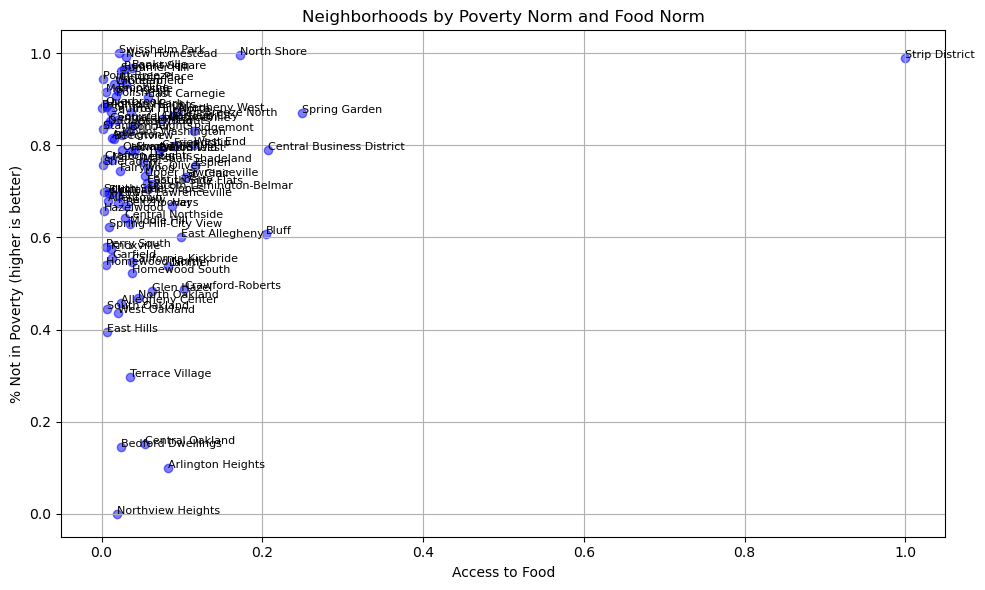

In [145]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(income_pov_food['Food_Norm'], income_pov_food['Poverty_Norm_Inverted'], c='blue', alpha=0.5)

plt.xlabel('Access to Food')
plt.ylabel('% Not in Poverty (higher is better)')
plt.title('Neighborhoods by Poverty Norm and Food Norm')

for i, txt in enumerate(income_pov_food['Neighborhood']):
    plt.annotate(txt, (income_pov_food['Food_Norm'][i], income_pov_food['Poverty_Norm_Inverted'][i]), fontsize=8)

plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
import pandas as pd

crime.csv = "https://data.wprdc.org/datastore/dump/e03a89dd-134a-4ee8-a2bd-62c40aeebc6f"
df = pd.read_csv(crime_url)

arrests_by_neighborhood = df.groupby('INCIDENTNEIGHBORHOOD').count()[df.columns[0]].reset_index()
arrests_by_neighborhood.columns = ['INCIDENTNEIGHBORHOOD', 'Number of Arrests']

sorted_arrests = arrests_by_neighborhood.sort_values(by='Number of Arrests', ascending=False)

pd.set_option('display.max_rows', None)

#print(sorted_arrests.to_string (index=False))

Here is every neighborhood in Pittsburgh ranked based on the number of arrests. This list might be a little too long but it is nice seeing individual values. Below we have is data in the form of a bar graph.

Text(0, 0.5, 'Number of Arrests')

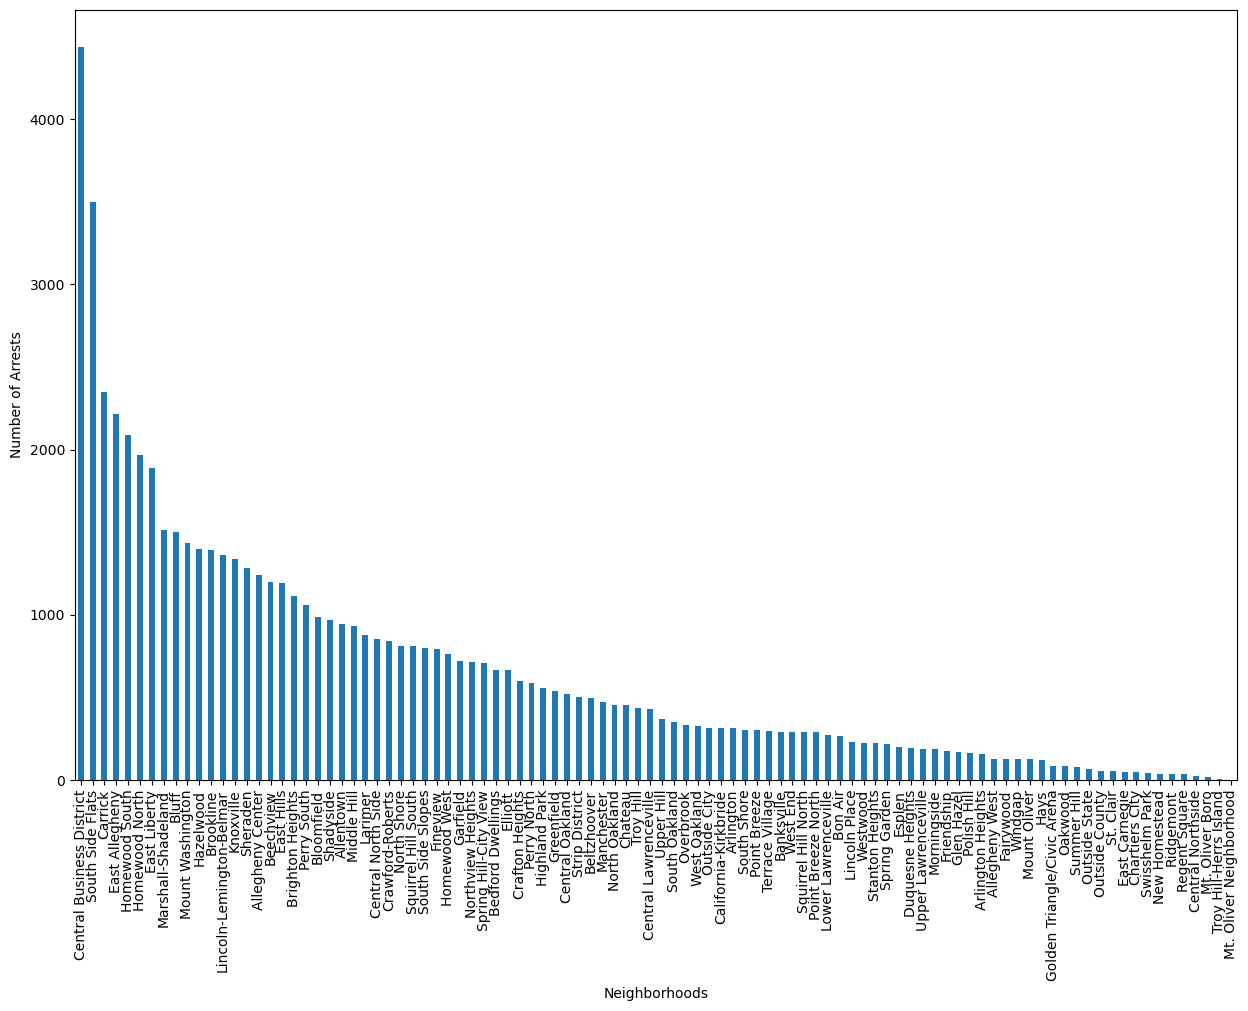

In [56]:
import pandas as pd

df = pd.read_csv(crime_url)

arrests_by_neighborhood = df.groupby('INCIDENTNEIGHBORHOOD').size().reset_index()
arrests_by_neighborhood.columns = ['INCIDENTNEIGHBORHOOD', 'Number of Arrests']

sorted_arrests = arrests_by_neighborhood.sort_values(by='Number of Arrests', ascending=False)

chart = sorted_arrests.plot.bar(x='INCIDENTNEIGHBORHOOD', y='Number of Arrests', legend=None, figsize= (15,10))

chart.set_xlabel('Neighborhoods')
chart.set_ylabel('Number of Arrests')

In [57]:
import pandas as pd

df = pd.read_csv(crime_url)

last_index_value = df.index[-1]

print("We are looking at:", last_index_value ,"arrests across Pittsburgh. This dataset ended 11/14/2023")

We are looking at: 66482 arrests across Pittsburgh. This dataset ended 11/14/2023


In [58]:
import pandas as pd

df = pd.read_csv(crime_url)

time = df.sort_values(by='ARRESTTIME')

print(time.loc[time.index[0], 'ARRESTTIME'])

print(time.loc[time.index[-1], 'ARRESTTIME'])

1998-03-11T11:30:00
2023-11-14T03:00:00


In [ ]:
import pandas as pd

df = pd.read_csv(crime_url)

offensesperneighborhood = df.groupby(['INCIDENTNEIGHBORHOOD', 'OFFENSES']).size().reset_index()

offensesperneighborhood.columns = ['INCIDENTNEIGHBORHOOD', 'OFFENSES', 'Count']



sort = offensesperneighborhood.sort_values(by=['INCIDENTNEIGHBORHOOD', 'Count'], ascending=[True, False])

neighborhoods = sort['INCIDENTNEIGHBORHOOD'].unique()
for neighborhood in neighborhoods:
    print(f"\n{neighborhood}:")
    top3offenses = sort[sort['INCIDENTNEIGHBORHOOD'] == neighborhood].head(3)
    for index, row in top3offenses.iterrows():
        print(f"{row['OFFENSES']}: {row['Count']} occurrences")


<Axes: ylabel='count'>

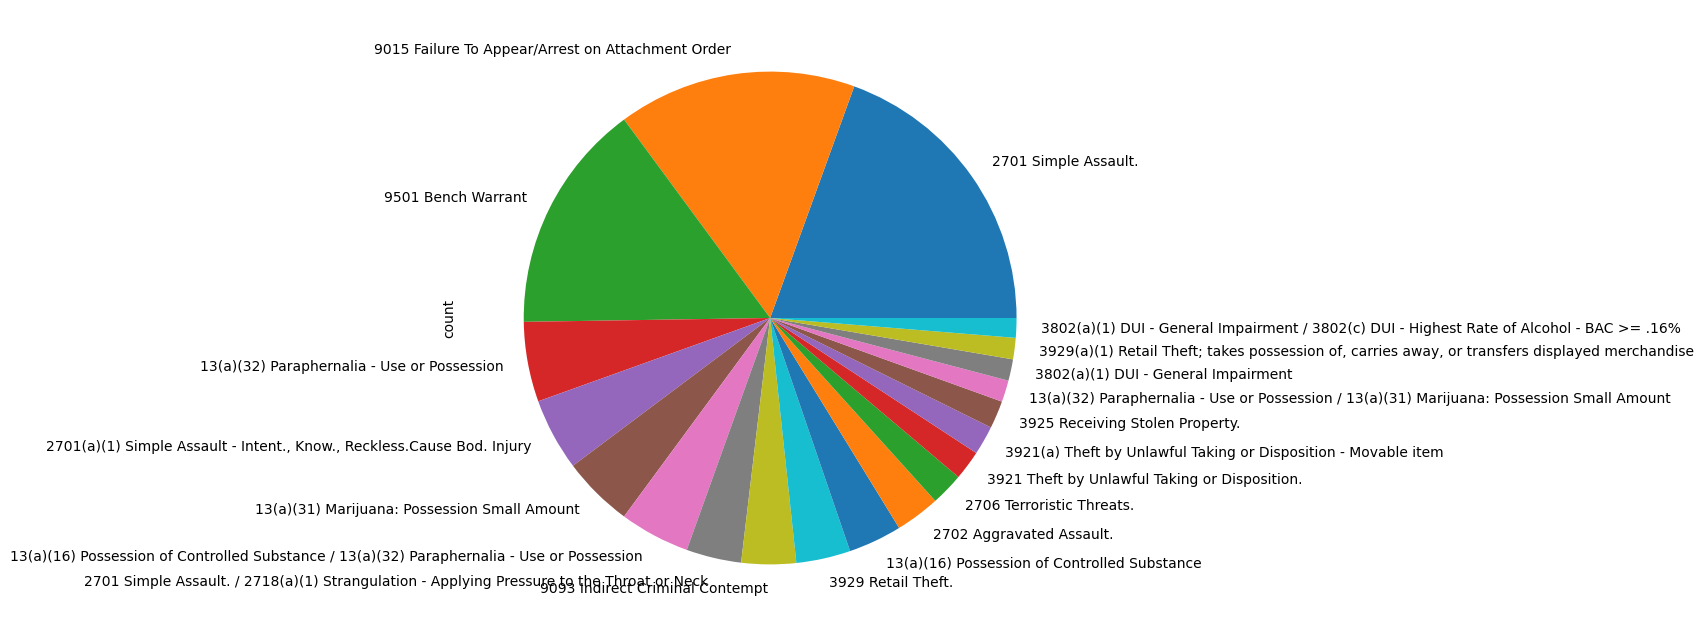

In [68]:
import pandas as pd

df = pd.read_csv(crime_url)

topoffenses = df["OFFENSES"].value_counts().nlargest(20)


topoffenses.plot.pie(figsize=(8, 8))



Text(0, 0.5, 'Population Size')

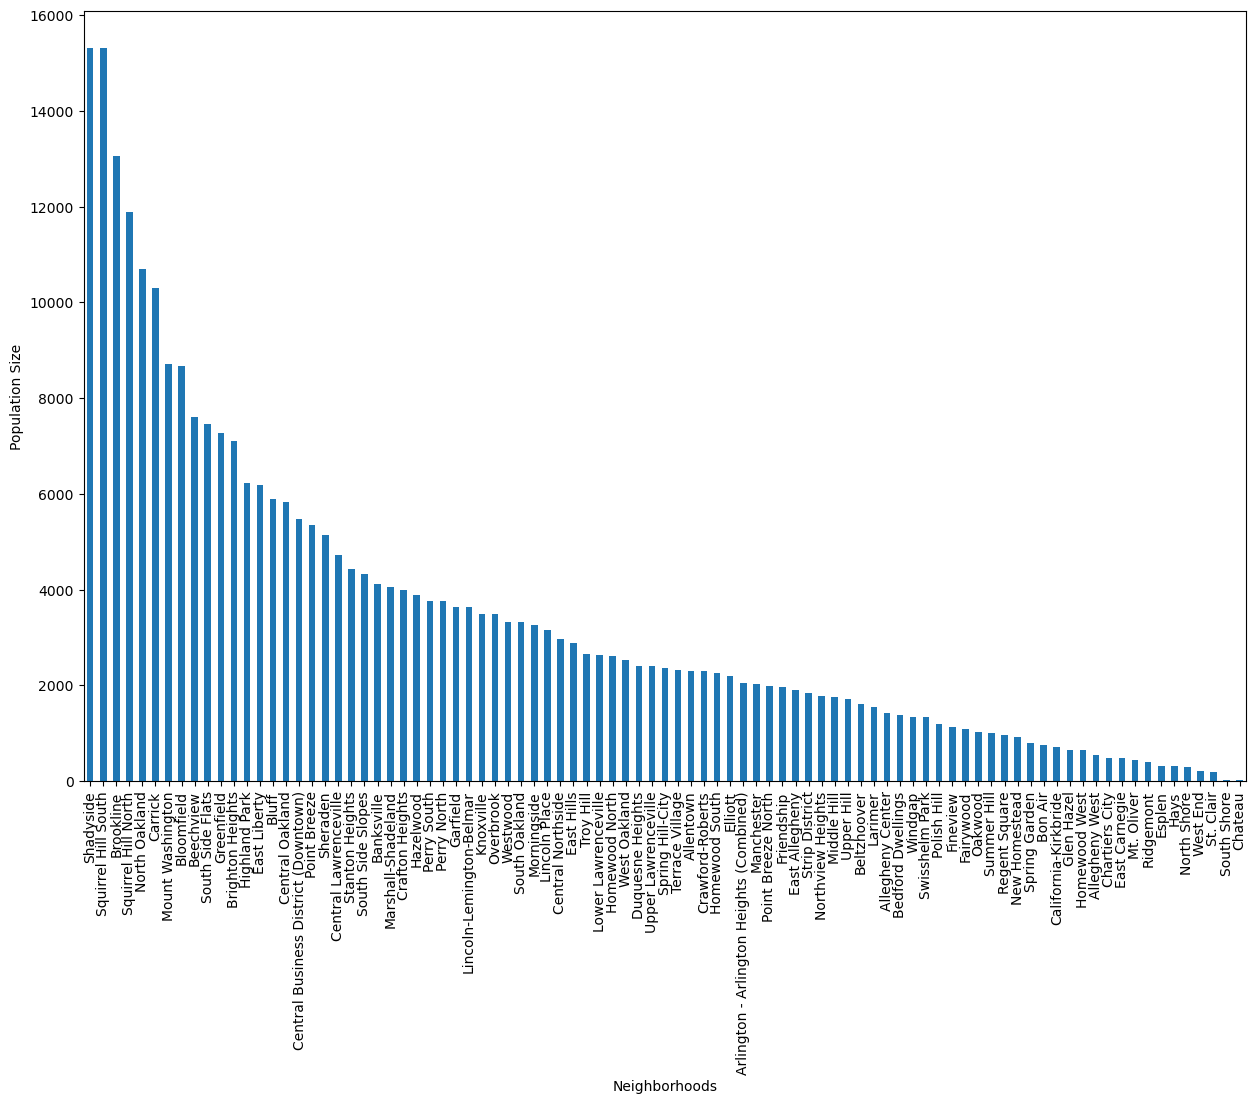

In [70]:
import pandas as pd

pop_url = 'https://data.wprdc.org/dataset/95af9f2c-61c8-446b-ae72-852e195684f3/resource/a8414ed5-c50f-417e-bb67-82b734660da6/download/preliminarycitypittsburghneighborhood_pl94171summary-2.csv'
pop = pd.read_csv(pop_url)

sortedpopulation = pop.sort_values(by='2020_Total_Population', ascending=False)

chart = sortedpopulation.plot.bar(x='Neighborhood', y='2020_Total_Population', legend=None, figsize= (15,10))

chart.set_xlabel('Neighborhoods')
chart.set_ylabel('Population Size')




In [71]:
pop = pd.read_csv(pop_url)

pop_2010 = pop['2010_Total_Population'].sum()
pop_2020= pop['2020_Total_Population'].sum()


print("Pittsburgh's population in 2010 was" ,pop_2010,". In 2020, Pittsburgh's population was", pop_2020, ". This reveals that Pittsburgh's population has decreased by", pop_2020-pop_2010, "over ten years.")


Pittsburgh's population in 2010 was 305704 . In 2020, Pittsburgh's population was 302971 . This reveals that Pittsburgh's population has decreased by -2733 over ten years.


In [72]:
import pandas as pd

crimedf= pd.read_csv(crime_url)
popdf = pd.read_csv(pop_url)

crimesin2020 = crimedf[crimedf['ARRESTTIME'].str.contains('2020', na=False)]
popin2020 = popdf.groupby('Neighborhood')['2020_Total_Population'].sum().reset_index()

merged = pd.merge(crimesin2020, popin2020, left_on='INCIDENTNEIGHBORHOOD', right_on='Neighborhood', how='inner')
crimesperneighborhood = merged.groupby('INCIDENTNEIGHBORHOOD').agg({merged.columns[0]: 'count', '2020_Total_Population': 'first'})
crimesperneighborhood = crimesperneighborhood.rename(columns={merged.columns[0]: '2020 Total Crimes', '2020_Total_Population': '2020 Total Population'})

crimesperneighborhood['Crime Rate'] = crimesperneighborhood['2020 Total Crimes'] / crimesperneighborhood['2020 Total Population']

sortedbyrate= crimesperneighborhood.sort_values(by='Crime Rate', ascending = False)

print(sortedbyrate)



                          2020 Total Crimes  2020 Total Population  Crime Rate
INCIDENTNEIGHBORHOOD                                                          
Chateau                                  37                     19    1.947368
South Shore                              37                     29    1.275862
North Shore                              58                    301    0.192691
Homewood West                           107                    642    0.166667
West End                                 31                    205    0.151220
Homewood South                          308                   2260    0.136283
East Allegheny                          239                   1903    0.125591
Allegheny Center                        155                   1419    0.109232
Homewood North                          282                   2617    0.107757
Fineview                                111                   1140    0.097368
Esplen                                   22         

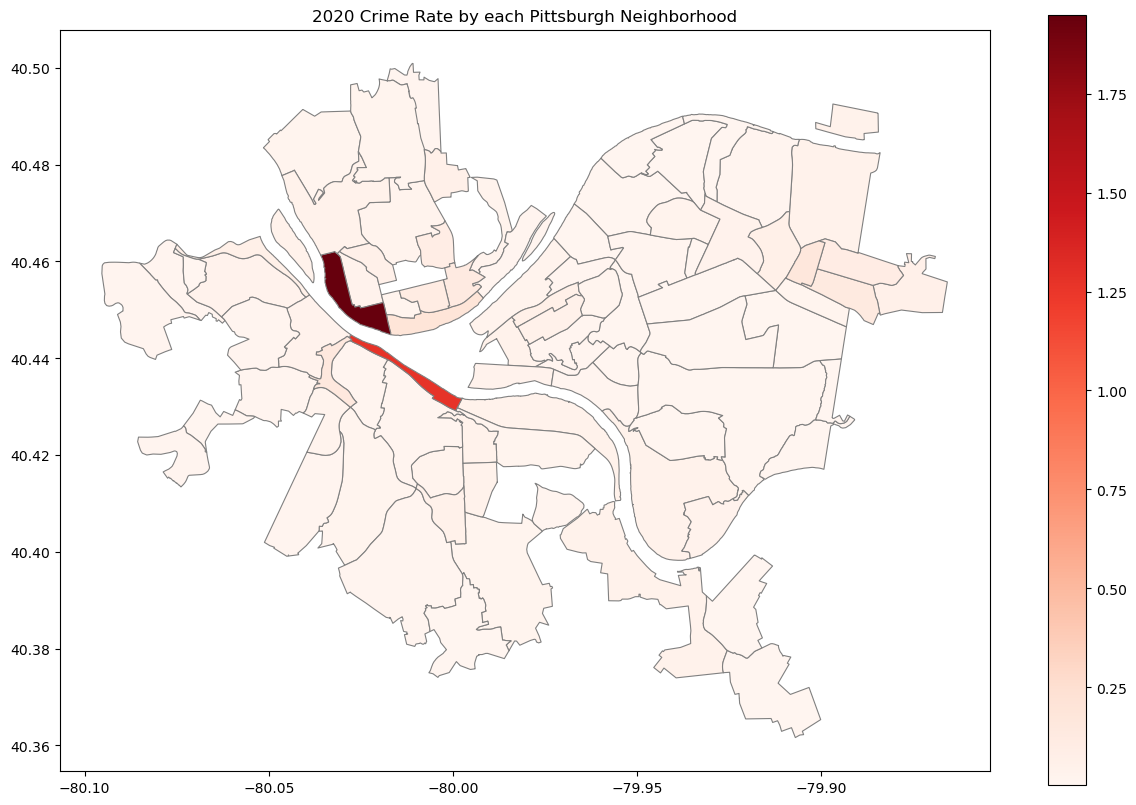

In [79]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plot

neighborhoods=gpd.read_file('Neighborhoods_.shp')

crimedf= pd.read_csv(crime_url)
popdf = pd.read_csv(pop_url)

crimesin2020 = crimedf[crimedf['ARRESTTIME'].str.contains('2020', na=False)]
popin2020 = popdf.groupby('Neighborhood')['2020_Total_Population'].sum().reset_index()

merged = pd.merge(crimesin2020, popin2020, left_on='INCIDENTNEIGHBORHOOD', right_on='Neighborhood', how='left')

crimesperneighborhood = merged.groupby('INCIDENTNEIGHBORHOOD').agg({merged.columns[0]: 'count', '2020_Total_Population': 'first'})
crimesperneighborhood = crimesperneighborhood.rename(columns={merged.columns[0]: '2020 Total Crimes', '2020_Total_Population': '2020 Total Population'})
crimesperneighborhood['Crime Rate'] = crimesperneighborhood['2020 Total Crimes'] / crimesperneighborhood['2020 Total Population']
crimesperneighborhood['Crime Rate'] = crimesperneighborhood['2020 Total Crimes'] / crimesperneighborhood['2020 Total Population']
neighborhoodcrime = neighborhoods.merge(crimesperneighborhood, left_on='hood', right_index=True, how='left')

fig, ax = plot.subplots(1, 1, figsize=(15, 10))
neighborhoodcrime.plot(column='Crime Rate', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.5', legend=True)
ax.set_title('2020 Crime Rate by each Pittsburgh Neighborhood')
plot.show()


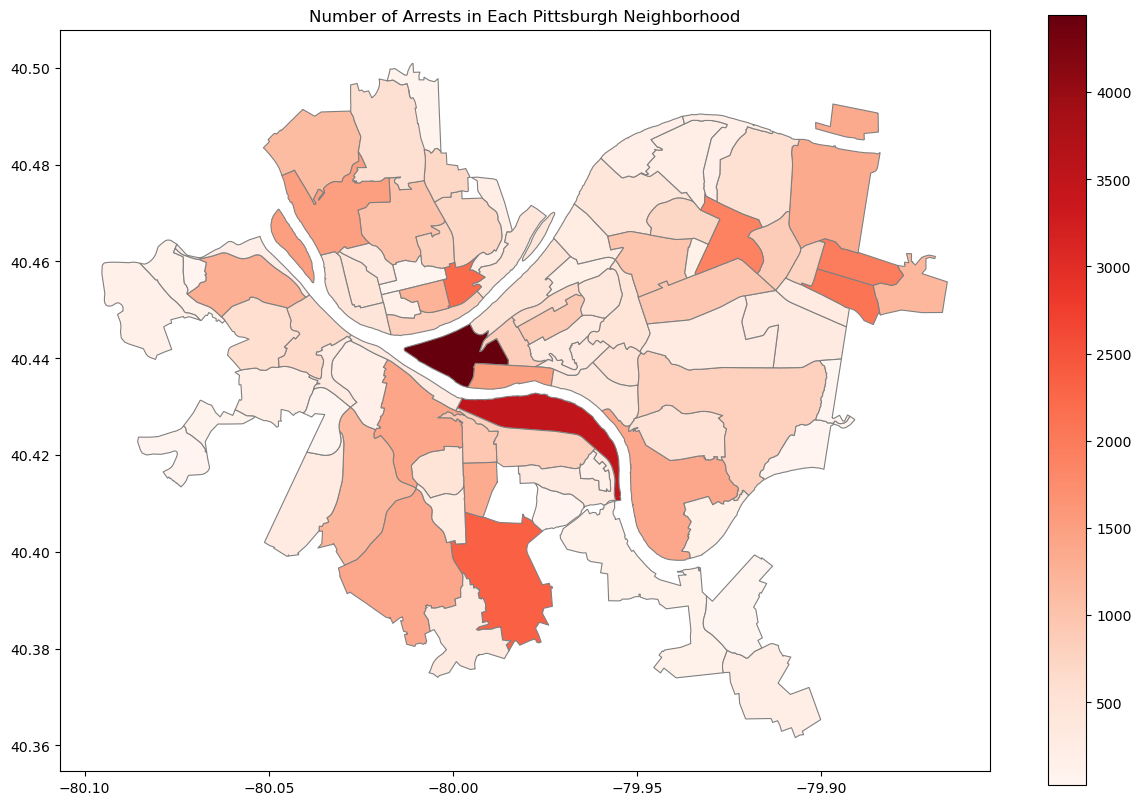

In [83]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plot

path = 'crime.csv'
df = pd.read_csv(crime_url)
neighborhoods=gpd.read_file('Neighborhoods_.shp')

arrests_by_neighborhood = df.groupby('INCIDENTNEIGHBORHOOD').size().reset_index()
arrests_by_neighborhood.columns = ['INCIDENTNEIGHBORHOOD', 'Number of Arrests']

mergedarrests = neighborhoods.merge(arrests_by_neighborhood, left_on='hood', right_on='INCIDENTNEIGHBORHOOD', how='left')


fig, ax = plot.subplots(1, 1, figsize=(15, 10))
mergedarrests.plot(column='Number of Arrests', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.5', legend=True)
ax.set_title('Number of Arrests in Each Pittsburgh Neighborhood')
plot.show()


As we can see from this map, South Side and the Central Business District have the highest number of arrests; however, when compared to crime rates, areas with a lower number of arrests have higher crime rate. This is because everything is relative to the population of each neighborhood.

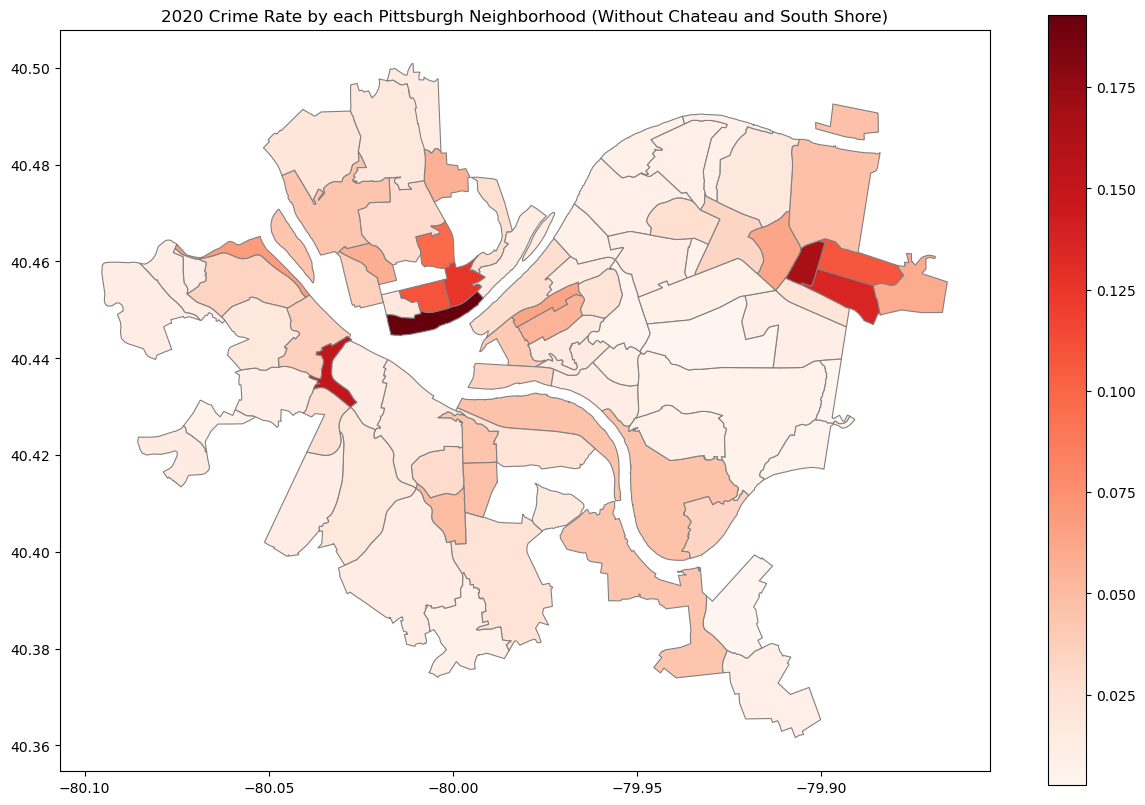

In [87]:

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plot

neighborhoods=gpd.read_file('Neighborhoods_.shp')
crime = pd.read_csv(crime_url)
pop = pd.read_csv(pop_url)

crimedf= pd.read_csv(crime_url)
popdf = pd.read_csv(pop_url)

crimedf = crimedf[~crimedf['INCIDENTNEIGHBORHOOD'].isin(['South Shore', 'Chateau'])]
popdf = popdf[~popdf['Neighborhood'].isin(['South Shore', 'Chateau'])]

crimesin2020 = crimedf[crimedf['ARRESTTIME'].str.contains('2020', na=False)]
popin2020 = popdf.groupby('Neighborhood')['2020_Total_Population'].sum().reset_index()

merged = pd.merge(crimesin2020, popin2020, left_on='INCIDENTNEIGHBORHOOD', right_on='Neighborhood', how='left')

crimesperneighborhood = merged.groupby('INCIDENTNEIGHBORHOOD').agg({merged.columns[0]: 'count', '2020_Total_Population': 'first'})
crimesperneighborhood = crimesperneighborhood.rename(columns={merged.columns[0]: '2020 Total Crimes', '2020_Total_Population': '2020 Total Population'})
crimesperneighborhood['Crime Rate'] = crimesperneighborhood['2020 Total Crimes'] / crimesperneighborhood['2020 Total Population']
crimesperneighborhood['Crime Rate'] = crimesperneighborhood['2020 Total Crimes'] / crimesperneighborhood['2020 Total Population']
neighborhoodcrime = neighborhoods.merge(crimesperneighborhood, left_on='hood', right_index=True, how='left')

fig, ax = plot.subplots(1, 1, figsize=(15, 10))
neighborhoodcrime.plot(column='Crime Rate', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.5', legend=True)
ax.set_title('2020 Crime Rate by each Pittsburgh Neighborhood (Without Chateau and South Shore)')
plot.show()

In [151]:
neighborhoodcrime = neighborhoodcrime.rename(columns={'hood': 'Neighborhood'})
neighborhoodcrime.describe()


,objectid,fid_blockg,aland10,awater10,shape_leng,fid_neighb,area,perimeter,neighbor_,neighbor_i,...,unique_id,sectors,shape_le_1,shape_ar_1,page_numbe,Shape__Are,Shape__Len,2020 Total Crimes,2020 Total Population,Crime Rate
count,90.000000,89.000000,8.900000e+01,89.000000,89.000000,89.000000,8.900000e+01,89.000000,89.000000,89.000000,...,89.000000,90.000000,89.000000,8.900000e+01,90.0,9.000000e+01,90.000000,86.000000,82.000000,82.000000
mean,59.888889,129.415730,5.815800e+05,42835.629213,12412.064402,48.741573,1.615615e+07,20608.022753,49.741573,2131.741573,...,43.741573,8.033333,20608.022835,1.615615e+07,15.0,1.716937e+07,21549.964804,86.034884,3532.036585,0.034840
std,133.902484,104.003476,6.194297e+05,137086.407260,7578.841663,26.607214,1.278760e+07,8684.320982,26.607214,26.607214,...,35.020944,4.547996,8684.321021,1.278760e+07,0.0,1.339842e+07,9473.544189,89.588398,3368.017200,0.038543
min,1.000000,0.000000,7.547200e+04,0.000000,3813.620989,1.000000,2.871538e+06,7443.400000,2.000000,2084.000000,...,0.000000,1.000000,7443.400290,2.871538e+06,15.0,2.876550e+06,7452.430274,3.000000,183.000000,0.002610
25%,24.250000,38.000000,2.437380e+05,0.000000,7297.919732,27.000000,7.785966e+06,14505.091000,28.000000,2110.000000,...,19.000000,4.000000,14505.091583,7.785965e+06,15.0,7.920672e+06,15014.343570,25.500000,1235.500000,0.010694
50%,46.500000,102.000000,3.505220e+05,0.000000,10355.074284,49.000000,1.198438e+07,19320.406000,50.000000,2132.000000,...,24.000000,7.000000,19320.407046,1.198437e+07,15.0,1.232054e+07,20055.381828,53.500000,2395.500000,0.019739
75%,68.750000,202.000000,8.073970e+05,0.000000,14820.149189,71.000000,2.101116e+07,24387.818000,72.000000,2154.000000,...,81.000000,12.000000,24387.818605,2.101116e+07,15.0,2.307674e+07,25463.860395,110.500000,4277.000000,0.043767
max,1292.000000,358.000000,4.488597e+06,854869.000000,56370.852913,94.000000,7.447013e+07,56384.668000,95.000000,2177.000000,...,113.000000,16.000000,56384.669081,7.447013e+07,15.0,7.447239e+07,56370.853074,543.000000,15317.000000,0.192691



## THE BEST NEIGHBORHOOD
##### Crime, poverty, and food access were the three metrics we used to determine livability, and with this data we concluded that Strip District. Although there were more arrests in the Strip District than many of the other neighborhoods, the actual crime rate per the population in the Script District for the year 2020 was less than 0.05. Furthermore, a majority of the crimes committed in Strip District were non-violent. Although there were 31 cases of simple assault, the other two highest offenses were bench warrants and failure to appear in court. Overall, the Strip District is a very safe neighborhood in Pittsburgh. When looking at poverty and access to food, the Strip District had one of the lowest poverty rates out of any neighborhood in Pittsburgh. Not only are the Strip District's poverty levels low, but the Strip District had the highest access to food out of any neighborhood in the dataframe. Overall, the Strip District is a relatively safe neighborhood with little violent crime, low levels of poverty, and high access to food, making it the ideal neighborhood to visit in Pittsburgh.


In [166]:
#MEGA DATASET COMBINING BOTH
merged_df = neighborhoodcrime.merge(income_pov_food, on='Neighborhood', how='inner')

selected_columns = ['Neighborhood', 'Crime Rate', 'Food_Norm', 'Poverty_Norm_Inverted']
final_df = merged_df[selected_columns]

#dealin with NaNs by setting em equal to average crime rate in burgh
crime_rate_avg = final_df['Crime Rate'].mean()
final_df['Crime Rate'] = final_df['Crime Rate'].fillna(crime_rate_avg)

#same for food column
food_avg = final_df['Food_Norm'].mean()
final_df['Food_Norm'] = final_df['Food_Norm'].fillna(crime_rate_avg)

#drop dumbass chateau north it's not a real place
final_df = final_df[final_df['Neighborhood'] != 'Chateau North']
final_df = final_df[final_df['Neighborhood'] != 'Chateau']



final_df['Sum_Columns'] = final_df['Crime Rate'] + final_df['Food_Norm'] + final_df['Poverty_Norm_Inverted']


C:\Users\Ben\AppData\Local\Temp\ipykernel_18900\1246275376.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Crime Rate'] = final_df['Crime Rate'].fillna(crime_rate_avg)
C:\Users\Ben\AppData\Local\Temp\ipykernel_18900\1246275376.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Food_Norm'] = final_df['Food_Norm'].fillna(crime_rate_avg)


In [172]:
final_df.sort_values("Sum_Columns", ascending=False).head(10)

,Neighborhood,Crime Rate,Food_Norm,Poverty_Norm_Inverted,Sum_Columns
4,Strip District,0.028184,1.000000,0.989288,2.017473
44,North Shore,0.192691,0.171703,0.995939,1.360333
26,Spring Garden,0.026718,0.249961,0.870828,1.147506
85,West End,0.151220,0.115303,0.800960,1.067482
5,Central Business District,0.034840,0.206488,0.790523,1.031852
78,New Homestead,0.003272,0.030779,0.993033,1.027083
35,Swisshelm Park,0.005228,0.021082,1.000000,1.026310
46,Banksville,0.012842,0.037237,0.968484,1.018563
8,Summer Hill,0.014028,0.023671,0.961391,0.999091
66,Regent Square,0.003090,0.028118,0.965223,0.996431



## CONCLUSION: 
##### We made our metric by normalizing and then combining our food accessibility, crime rate, and poverty rate statistics, proving Strip District to be a clear winner. With its combination of low poverty ( 8.7%), a crime rate in the bottom 2.8 percent, and the highest number of grocery stores per capita of any neighborhood in Pittsburgh, our data points to Strip district being the best neighborhood in Pittsburgh.

##### Crime, poverty, and food access were the three metrics we used to determine livability, and with this data we concluded that the Strip District is the best neighborhood in Pittsburgh. Although there were more arrests in the Strip District than many of the other neighborhoods, the actual crime rate per the Script District's population for the year 2020 was less than 0.05. Furthermore, a majority of the crimes committed in Strip District were non-violent. Although there were 31 cases of simple assault, the other two highest offenses were bench warrants and failure to appear in court. Overall, the Strip District is a very safe neighborhood in Pittsburgh. When looking at poverty and access to food, the Strip District had one of the lowest poverty rates out of any neighborhood in Pittsburgh. Not only are the Strip District's poverty levels low, but the Strip District had the highest access to food out of any neighborhood in the dataframe. Overall, the Strip District is a relatively safe neighborhood with little violent crime, low levels of poverty, and high access to food, making it the ideal neighborhood to visit in Pittsburgh.

### BEN: 
##### This aligns with my opinion of the Strip. I love to cook, and I like exploring different cuisines by getting uncommon ingredients at ethnic grocery stores, which Strip District is full of. The low poverty is also a plus, as well as, I guess, the safety. Neighborhoods I considered Shadyside or maybe Squirrel Hill to be the nicest neighborhoods, but our data showed that they had surprisingly average rates of poverty and crime. 

### Travis:

##### This data aligns with my view of the Strip District as well. I have only been to the Strip District a few times; however, every time I have visited, I am always drawn to the diversity of food in the Strip District. Additionally, I have always felt that the Strip District is a safe neighborhood with a strong sense of community engrained into the Strip District's culture. The dataframes we analyzed confirm the Strip District's safety, low levels of poverty, and wide variety of food.